# Model_7 : Transfert Learning based on Model_1 on top of MobileNetV2 with Fine-Tuning, Anti-Overfitting, 4-Way Split

## 1. Imports & Setup

In [1]:
# Load libraries and configuration for training.

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import kagglehub

## 2. Download Dataset

In [2]:
# Load the Animals-10 dataset from Kaggle using kagglehub.
#
# The dataset is structured as folders, one per class.

# Download dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", path)

# Dataset path and parameters
dataset_path = "/kaggle/input/animals10/raw-img"
IMG_SIZE = (160, 160)

Path to dataset files: /kaggle/input/animals10


## 3. Load & Preprocess Data
Convert the dataset into NumPy arrays and preprocess using MobileNetV2 pipeline.


In [3]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True
)

# Translate class names from Italian to English
class_names = dataset.class_names
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "ragno": "spider"
}
class_names = [translate.get(name, name) for name in class_names]
translated_class_names = [translate.get(name, name) for name in class_names]

# Convert tensors to NumPy
x, y = [], []
for img, label in dataset:
    x.append(img.numpy())
    y.append(label.numpy())

x = np.array(x)
y = np.array(y)

# Preprocess images
x = preprocess_input(x)

Found 26179 files belonging to 10 classes.


## 4. Split Dataset
Create 4-way split (train, validation, test, unseen).

In [4]:
# 4-Way Split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_val, x_holdout, y_val, y_holdout = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# ⚠️ Ensure even sample count for last split to avoid mismatch
if len(x_holdout) % 2 != 0:
    x_holdout = x_holdout[:-1]
    y_holdout = y_holdout[:-1]  # Trim 1 sample to make even

x_test, x_pred, y_test, y_pred_actual = train_test_split(x_holdout, y_holdout, test_size=0.5, random_state=42, stratify=y_holdout)

num_classes = len(class_names)
print("Train:", x_train.shape, y_train.shape)
print("Validation:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)
print("Prediction:", x_pred.shape, y_pred_actual.shape)

Train: (18325, 160, 160, 3) (18325,)
Validation: (3927, 160, 160, 3) (3927,)
Test: (1963, 160, 160, 3) (1963,)
Prediction: (1963, 160, 160, 3) (1963,)


## 5. Define Model

In [5]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = callbacks.ModelCheckpoint("./models/best_model_mobilenetv2.keras", save_best_only=True, monitor="val_loss", mode="min")
earlystop_cb = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 6. Train Phase 1

In [6]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint_cb, earlystop_cb])


Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.7696 - loss: 0.7585 - val_accuracy: 0.9481 - val_loss: 0.1746
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9259 - loss: 0.2439 - val_accuracy: 0.9514 - val_loss: 0.1516
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9382 - loss: 0.2018 - val_accuracy: 0.9539 - val_loss: 0.1482
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9377 - loss: 0.1948 - val_accuracy: 0.9552 - val_loss: 0.1514
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9465 - loss: 0.1680 - val_accuracy: 0.9549 - val_loss: 0.1474
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9453 - loss: 0.1675 - val_accuracy: 0.9542 - val_loss: 0.1518
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9507 - loss: 0.1510 - val_accuracy: 0.9587 - val_loss: 0.1477
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9496 - loss: 0.1509 - 

## 7. Fine-Tune Phase 2


In [7]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.8748 - loss: 0.4107 - val_accuracy: 0.9582 - val_loss: 0.1507
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9152 - loss: 0.2790 - val_accuracy: 0.9598 - val_loss: 0.1467
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9257 - loss: 0.2273 - val_accuracy: 0.9610 - val_loss: 0.1446
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9329 - loss: 0.2054 - val_accuracy: 0.9610 - val_loss: 0.1407
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9384 - loss: 0.1876 - val_accuracy: 0.9613 - val_loss: 0.1409
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9442 - loss: 0.1698 - val_accuracy: 0.9633 - val_loss: 0.1393
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9557 - loss: 0.1429 - val_accuracy: 0.9643 - val_loss: 0.1370
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9549 - loss: 0.1397 - 

## 8. Plot Accuracy and Loss

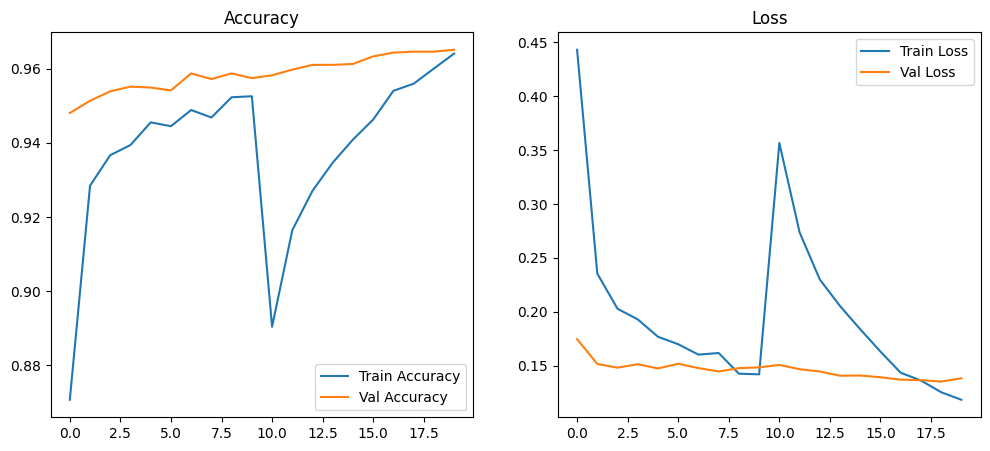

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


## 9. Evaluate on Test Set

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step

Classification Report:
              precision    recall  f1-score   support

         dog       0.96      0.97      0.96       365
       horse       0.95      0.95      0.95       197
    elephant       0.97      0.94      0.95       109
   butterfly       0.99      0.96      0.98       158
     chicken       0.97      0.97      0.97       232
         cat       0.97      0.94      0.95       125
         cow       0.92      0.91      0.91       140
       sheep       0.93      0.93      0.93       136
      spider       0.99      0.99      0.99       361
    squirrel       0.95      0.99      0.97       140

    accuracy                           0.96      1963
   macro avg       0.96      0.96      0.96      1963
weighted avg       0.96      0.96      0.96      1963



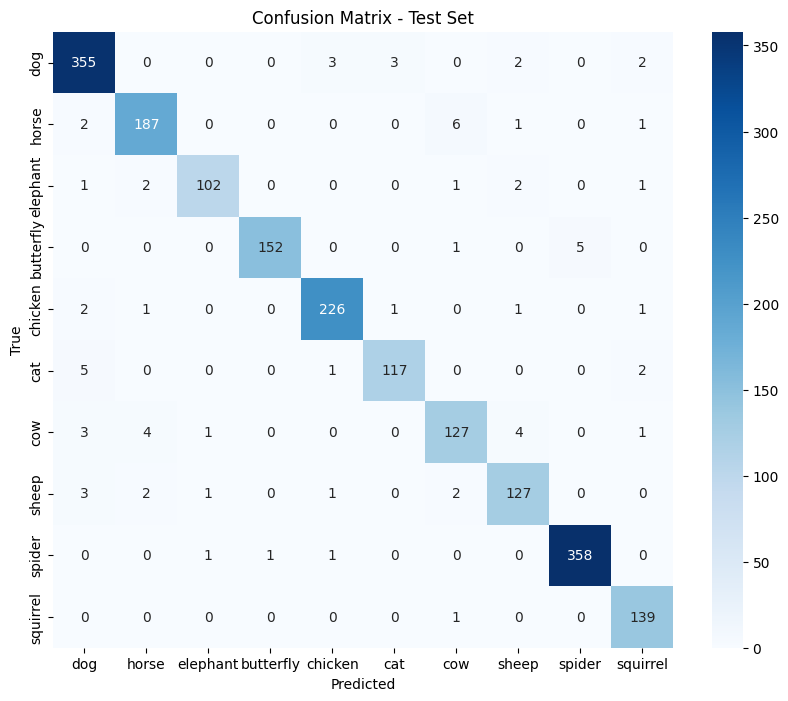

In [9]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=translated_class_names))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=translated_class_names, yticklabels=translated_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.savefig("conf_matrix_test.png")
plt.show()

## 10. Visualize Misclassified Samples

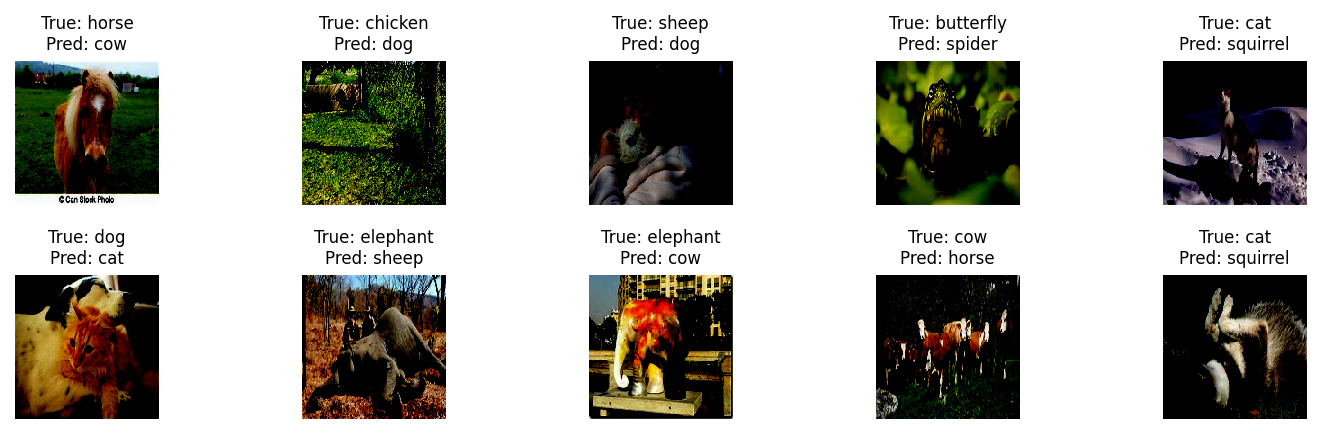

In [10]:
misclassified_indices = np.where(y_pred != y_test)[0]
plt.figure(figsize=(10, 3), dpi=150)
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx], interpolation='none')
    plt.title(f"True: {translated_class_names[y_test[idx]]}\nPred: {translated_class_names[y_pred[idx]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 11. Final Metrics Summary

In [11]:
model.summary()
loss, acc = model.evaluate(x_test, y_test)
print("\n\U0001F4C9 Test Loss:", loss)
print("\U0001F4CA Test Accuracy (from model.evaluate):", acc)
print("\U0001F4CA Test Accuracy (from sklearn):", accuracy_score(y_test, y_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,228,768 (23.76 MB)

 Trainable params: 1,944,074 (7.42 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,888,150 (14.83 MB)

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9599 - loss: 0.1099

📉 Test Loss: 0.1112590879201889
📊 Test Accuracy (from model.evaluate): 0.9628120064735413
📊 Test Accuracy (from sklearn): 0.9628120224146715


## 12. Final Evaluation on Prediction Set

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Prediction Set Classification Report:
              precision    recall  f1-score   support

         dog       0.95      0.95      0.95       365
       horse       0.93      0.94      0.94       196
    elephant       0.96      0.93      0.94       108
   butterfly       0.97      0.94      0.96       159
     chicken       0.94      0.97      0.96       232
         cat       0.97      0.93      0.95       125
         cow       0.88      0.92      0.90       140
       sheep       0.95      0.91      0.93       137
      spider       0.99      0.98      0.98       362
    squirrel       0.96      0.99      0.97       139

    accuracy                           0.95      1963
   macro avg       0.95      0.95      0.95      1963
weighted avg       0.95      0.95      0.95      1963



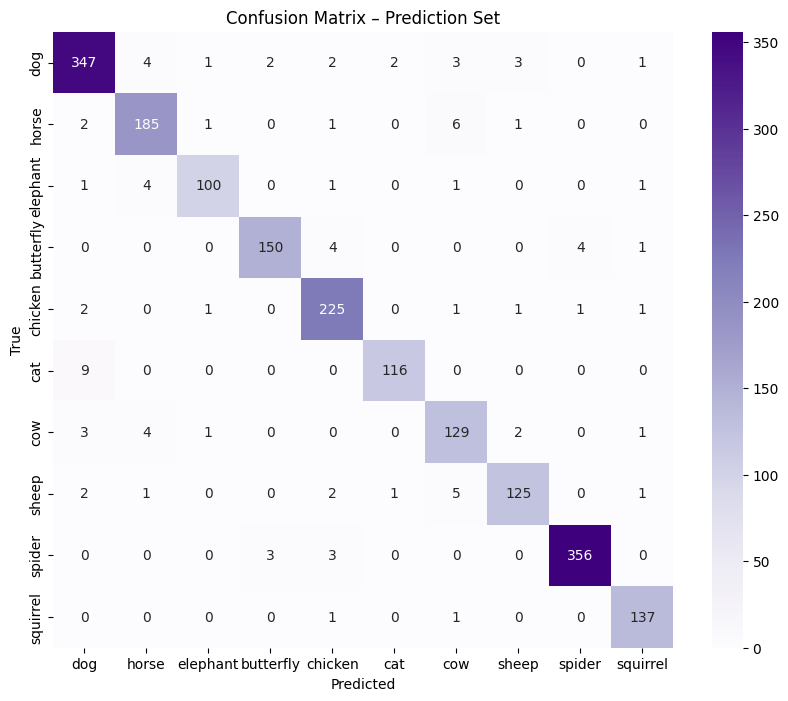

In [12]:
y_pred_from_model = np.argmax(model.predict(x_pred), axis=1)
assert len(y_pred_actual) == len(y_pred_from_model), "Mismatch in prediction sample sizes!"
print("\nPrediction Set Classification Report:")
print(classification_report(y_pred_actual, y_pred_from_model, target_names=translated_class_names))

conf_matrix_pred = confusion_matrix(y_pred_actual, y_pred_from_model)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_pred, annot=True, fmt="d", cmap="Purples", xticklabels=translated_class_names, yticklabels=translated_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Prediction Set")
plt.savefig("conf_matrix_prediction.png")
plt.show()

## 13. Save Prediction Results to CSV

In [13]:
prediction_df = pd.DataFrame({
    "True Label": [translated_class_names[i] for i in y_pred_actual],
    "Predicted Label": [translated_class_names[i] for i in y_pred_from_model]
})
prediction_df.to_csv("prediction_results.csv", index=False)
print("Saved as prediction_results.csv")

Saved as prediction_results.csv


## 14. Accuracy Comparison

In [14]:
print("\nAccuracy Comparison:")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Prediction Set Accuracy: {accuracy_score(y_pred_actual, y_pred_from_model):.4f}")



Accuracy Comparison:
Test Set Accuracy: 0.9628
Prediction Set Accuracy: 0.9526


## 12. Model prediction on random animal image for the net
Download the image (specific to google colab)

In [15]:
from google.colab import files
uploaded = files.upload()


Saving cat_2.jpg to cat_2.jpg


Preprocessing the image

In [16]:
from PIL import Image
import numpy as np

def preprocess_image_from_path(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

Predict the result

In [17]:
img_array = preprocess_image_from_path('cat_2.jpg')
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]
print("Predicted class:", class_names[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: cat
